Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import time
import random


In [2]:
seed = 1337
random.seed(seed)
np.random.seed(seed)

Using device: cuda


In [3]:
data_path = "../Data/data_air_15000_liq_15000_complete.csv"
df = pd.read_csv(data_path, sep=',')

ts_columns = [col for col in df.columns if col.startswith('TS_')]

features = df[ts_columns].values
label_encoder = LabelEncoder()
classification_targets = label_encoder.fit_transform(df['prefix'].values)
regression_targets = df[['theta_i_deg', 'a', 'b']].values

classes = label_encoder.classes_
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

# Split data into train, test, validation 80/10/10
X_train, X_temp, class_train, class_temp, reg_train, reg_temp = train_test_split(
    features, classification_targets, regression_targets,
    test_size=0.2, random_state=seed
)
X_val, X_test, class_val, class_test, reg_val, reg_test = train_test_split(
    X_temp, class_temp, reg_temp,
    test_size=0.5, random_state=seed
)

# Normalize features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train_normalized = (X_train - X_train_mean) / X_train_std
X_val_normalized = (X_val - X_train_mean) / X_train_std
X_test_normalized = (X_test - X_train_mean) / X_train_std

# Normalize regression targets
reg_train_mean = reg_train.mean(axis=0)
reg_train_std = reg_train.std(axis=0)
reg_train_normalized = (reg_train - reg_train_mean) / reg_train_std
reg_val_normalized = (reg_val - reg_train_mean) / reg_train_std
reg_test_normalized = (reg_test - reg_train_mean) / reg_train_std

reg_cols = ['theta_i_deg', 'a', 'b', 'alpha']

#Colors for viz
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']


Number of classes: 2
Classes: ['airfilled' 'liquid']


Evaluate

In [4]:
def evaluate_classification(y_true, y_pred, classes):
    accuracy = np.mean(y_true == y_pred)
    print(f"Classification Accuracy: {accuracy:.4f}")
            
    return accuracy


def evaluate_regression(y_true, y_pred, target_names, norm_mean, norm_std, model_name=None):
    denorm_true = y_true * norm_std[:3] + norm_mean[:3]
    denorm_pred = y_pred * norm_std[:3] + norm_mean[:3]
    
    # Add alpha calculation for true and predicted values
    alpha_true = denorm_true[:, 1] / denorm_true[:, 2]  # a/b for true values
    alpha_pred = denorm_pred[:, 1] / denorm_pred[:, 2]  # a/b for predicted values
    
    
    max_alpha = np.max(alpha_true)
    alpha_pred = np.clip(alpha_pred, 1, max_alpha)


    # Combine all values
    full_true = np.column_stack([denorm_true, alpha_true])
    full_pred = np.column_stack([denorm_pred, alpha_pred])
    
    metrics = {}
    
    for i, name in enumerate(target_names):
        if i < 3:
            rmse = np.sqrt(mean_squared_error(full_true[:, i], full_pred[:, i]))
            r2 = r2_score(full_true[:, i], full_pred[:, i])
        #For alpha
        else:
            rmse = np.sqrt(mean_squared_error(alpha_true, alpha_pred))
            r2 = r2_score(alpha_true, alpha_pred)
        
        print(f"\nMetrics for {name}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
        metrics[name] = {
            'rmse': rmse,
            'r2': r2
        }
    
   
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2)
    
    axes = [
        fig.add_subplot(gs[0, 0]), 
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1])
    ]
    

    if model_name:
        plt.suptitle(f'Model: {model_name}', fontsize=16, y=0.98)
    
    for i, name in enumerate(target_names):
        ax = axes[i]
        
        if i < 3:
            true_values = full_true[:, i]
            pred_values = full_pred[:, i]
        #For alpha
        else:
            true_values = alpha_true
            pred_values = alpha_pred

        
        color = colors[i % len(colors)]
        ax.scatter(true_values, pred_values, alpha=0.5, color=color)
        
    
        min_val = min(true_values.min(), pred_values.min())
        max_val = max(true_values.max(), pred_values.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Identity Line')
        
        ax.set_xlabel(f'True {name}')
        ax.set_ylabel(f'Predicted {name}')
        ax.set_title(f'{name}\nRMSE: {metrics[name]["rmse"]:.3f}, R²: {metrics[name]["r2"]:.3f}')
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    return metrics


## Models

In [5]:
## 1. KNN Models
## USED K = 5 LIKE COTTER et al.

# KNN for Classification
def train_knn_classifier(X_train, y_train):
    print("Training KNN Classifier...")
    start_time = time.time()
    
    # Create and train the model
    knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
    knn_clf.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return knn_clf

# KNN for Regression
def train_knn_regressors(X_train, y_train):
    print("Training KNN Regressors for each target variable...")
    start_time = time.time()
    
    knn_regs = []
    for i in range(3):  # For theta, a, b
        knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1)
        knn_reg.fit(X_train, y_train[:, i])
        knn_regs.append(knn_reg)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return knn_regs

## 2. SVM Models
# SVM for Classification
def train_svm_classifier(X_train, y_train):
    print("Training SVM Classifier...")
    start_time = time.time()
    

    sample_size = len(X_train)
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample, y_sample = X_train[indices], y_train[indices]
    
    # Create and train the model
    svm_clf = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')
    svm_clf.fit(X_sample, y_sample)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds (used {sample_size} samples)")
    
    return svm_clf

# SVM for Regression
def train_svm_regressors(X_train, y_train):
    print("Training SVM Regressors for each target variable...")
    start_time = time.time()
    
    sample_size = len(X_train)
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample, y_sample = X_train[indices], y_train[indices, :3] 
    
    svm_regs = []
    for i in range(3):  # For theta, a, b
        svm_reg = SVR(kernel='rbf', C=1.0, gamma='scale')
        svm_reg.fit(X_sample, y_sample[:, i])
        svm_regs.append(svm_reg)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds (used {sample_size} samples)")
    
    return svm_regs

In [6]:
## 3. Random Forest Models
# Random Forest for Classification
def train_rf_classifier(X_train, y_train):
    print("Training Random Forest Classifier...")
    start_time = time.time()
    
    # Create and train the model
    rf_clf = RandomForestClassifier(
        n_estimators=5000,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        n_jobs=-2,
        random_state=seed,
    )
    rf_clf.fit(X_train, y_train)
        
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return rf_clf

# Random Forest for Regression
def train_rf_regressor(X_train, y_train):
    print("Training Random Forest Regressor...")
    start_time = time.time()
    
    rf_regs = []
    for i in range(3):  # For theta, a, b
        rf_reg = RandomForestRegressor(
            n_estimators=5000,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            bootstrap=True,
            n_jobs=-2,
            random_state=seed
        )
        rf_reg.fit(X_train, y_train[:, i])
        rf_regs.append(rf_reg)
            
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    

    class RFMultiOutputWrapper:
        def __init__(self, regressors):
            self.regressors = regressors
            
        def predict(self, X):
            return np.column_stack([reg.predict(X) for reg in self.regressors])
    
    return RFMultiOutputWrapper(rf_regs)




=== KNN Models ===
Training KNN Classifier...
Training completed in 0.01 seconds
Training KNN Regressors for each target variable...
Training completed in 0.03 seconds

Evaluating KNN Classification model...
Classification Accuracy: 1.0000

Evaluating KNN Regression models...

Metrics for theta_i_deg:
RMSE: 12.8665
R² Score: 0.7513

Metrics for a:
RMSE: 0.0060
R² Score: 0.8982

Metrics for b:
RMSE: 0.0011
R² Score: 0.9312

Metrics for alpha:
RMSE: 1.4949
R² Score: 0.4419


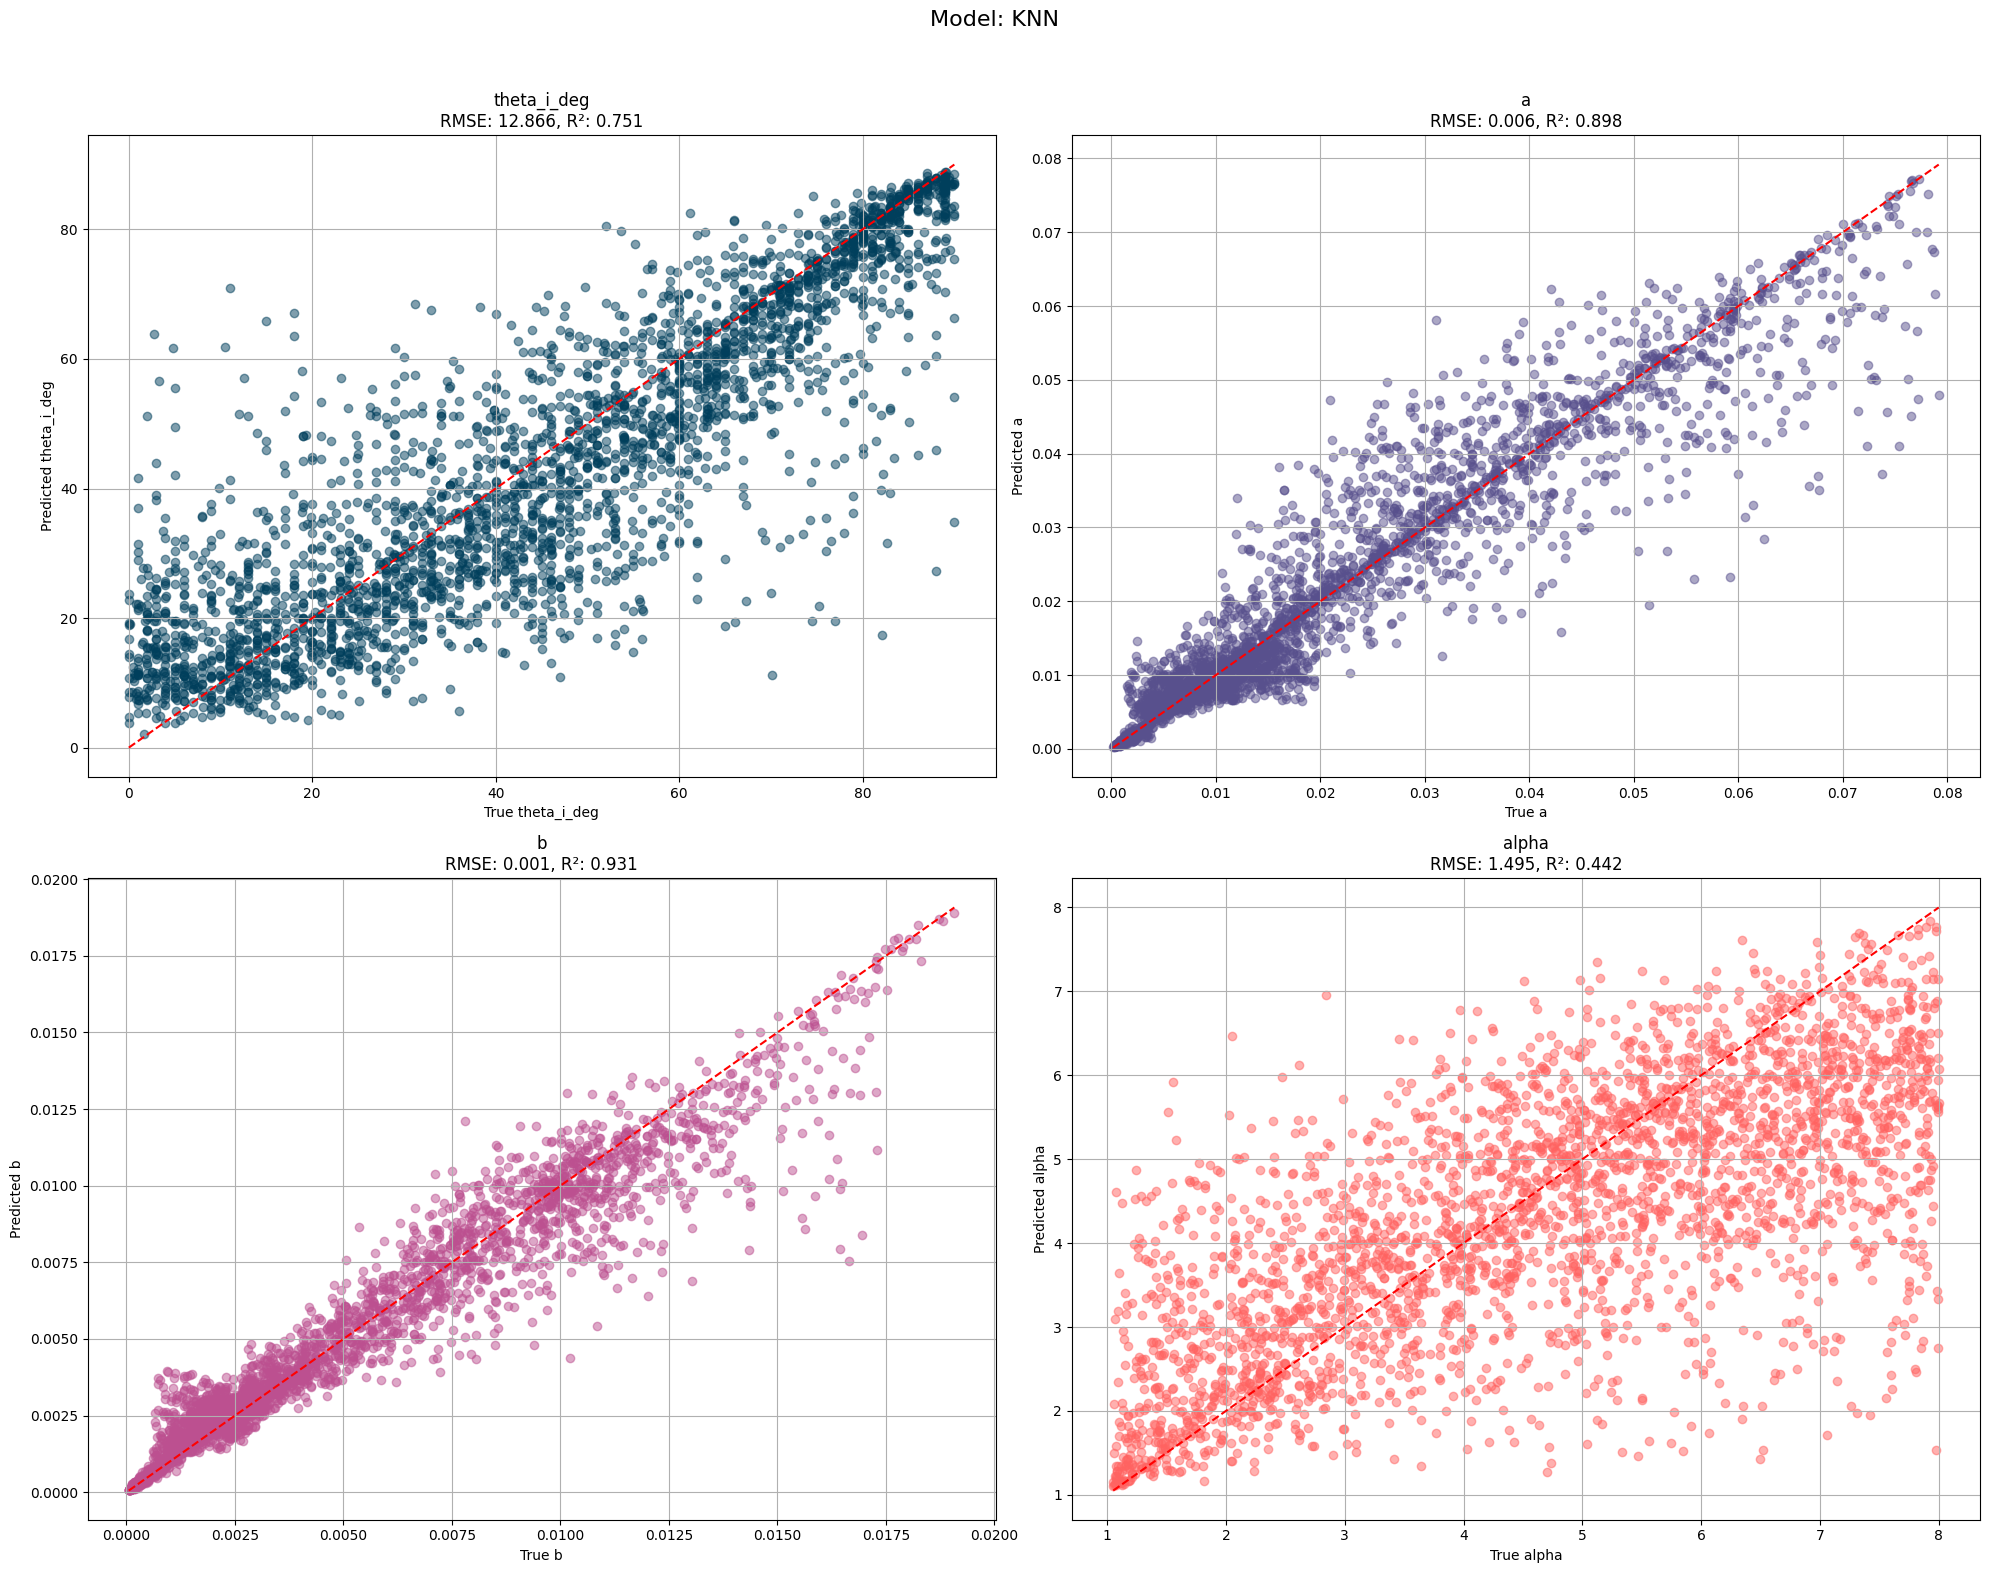


=== SVM Models ===
Training SVM Classifier...
Training completed in 14.31 seconds (used 24000 samples)
Training SVM Regressors for each target variable...
Training completed in 151.52 seconds (used 24000 samples)

Evaluating SVM Classification model...
Classification Accuracy: 1.0000

Evaluating SVM Regression models...

Metrics for theta_i_deg:
RMSE: 13.0992
R² Score: 0.7422

Metrics for a:
RMSE: 0.0086
R² Score: 0.7951

Metrics for b:
RMSE: 0.0013
R² Score: 0.9106

Metrics for alpha:
RMSE: 1.8028
R² Score: 0.1882


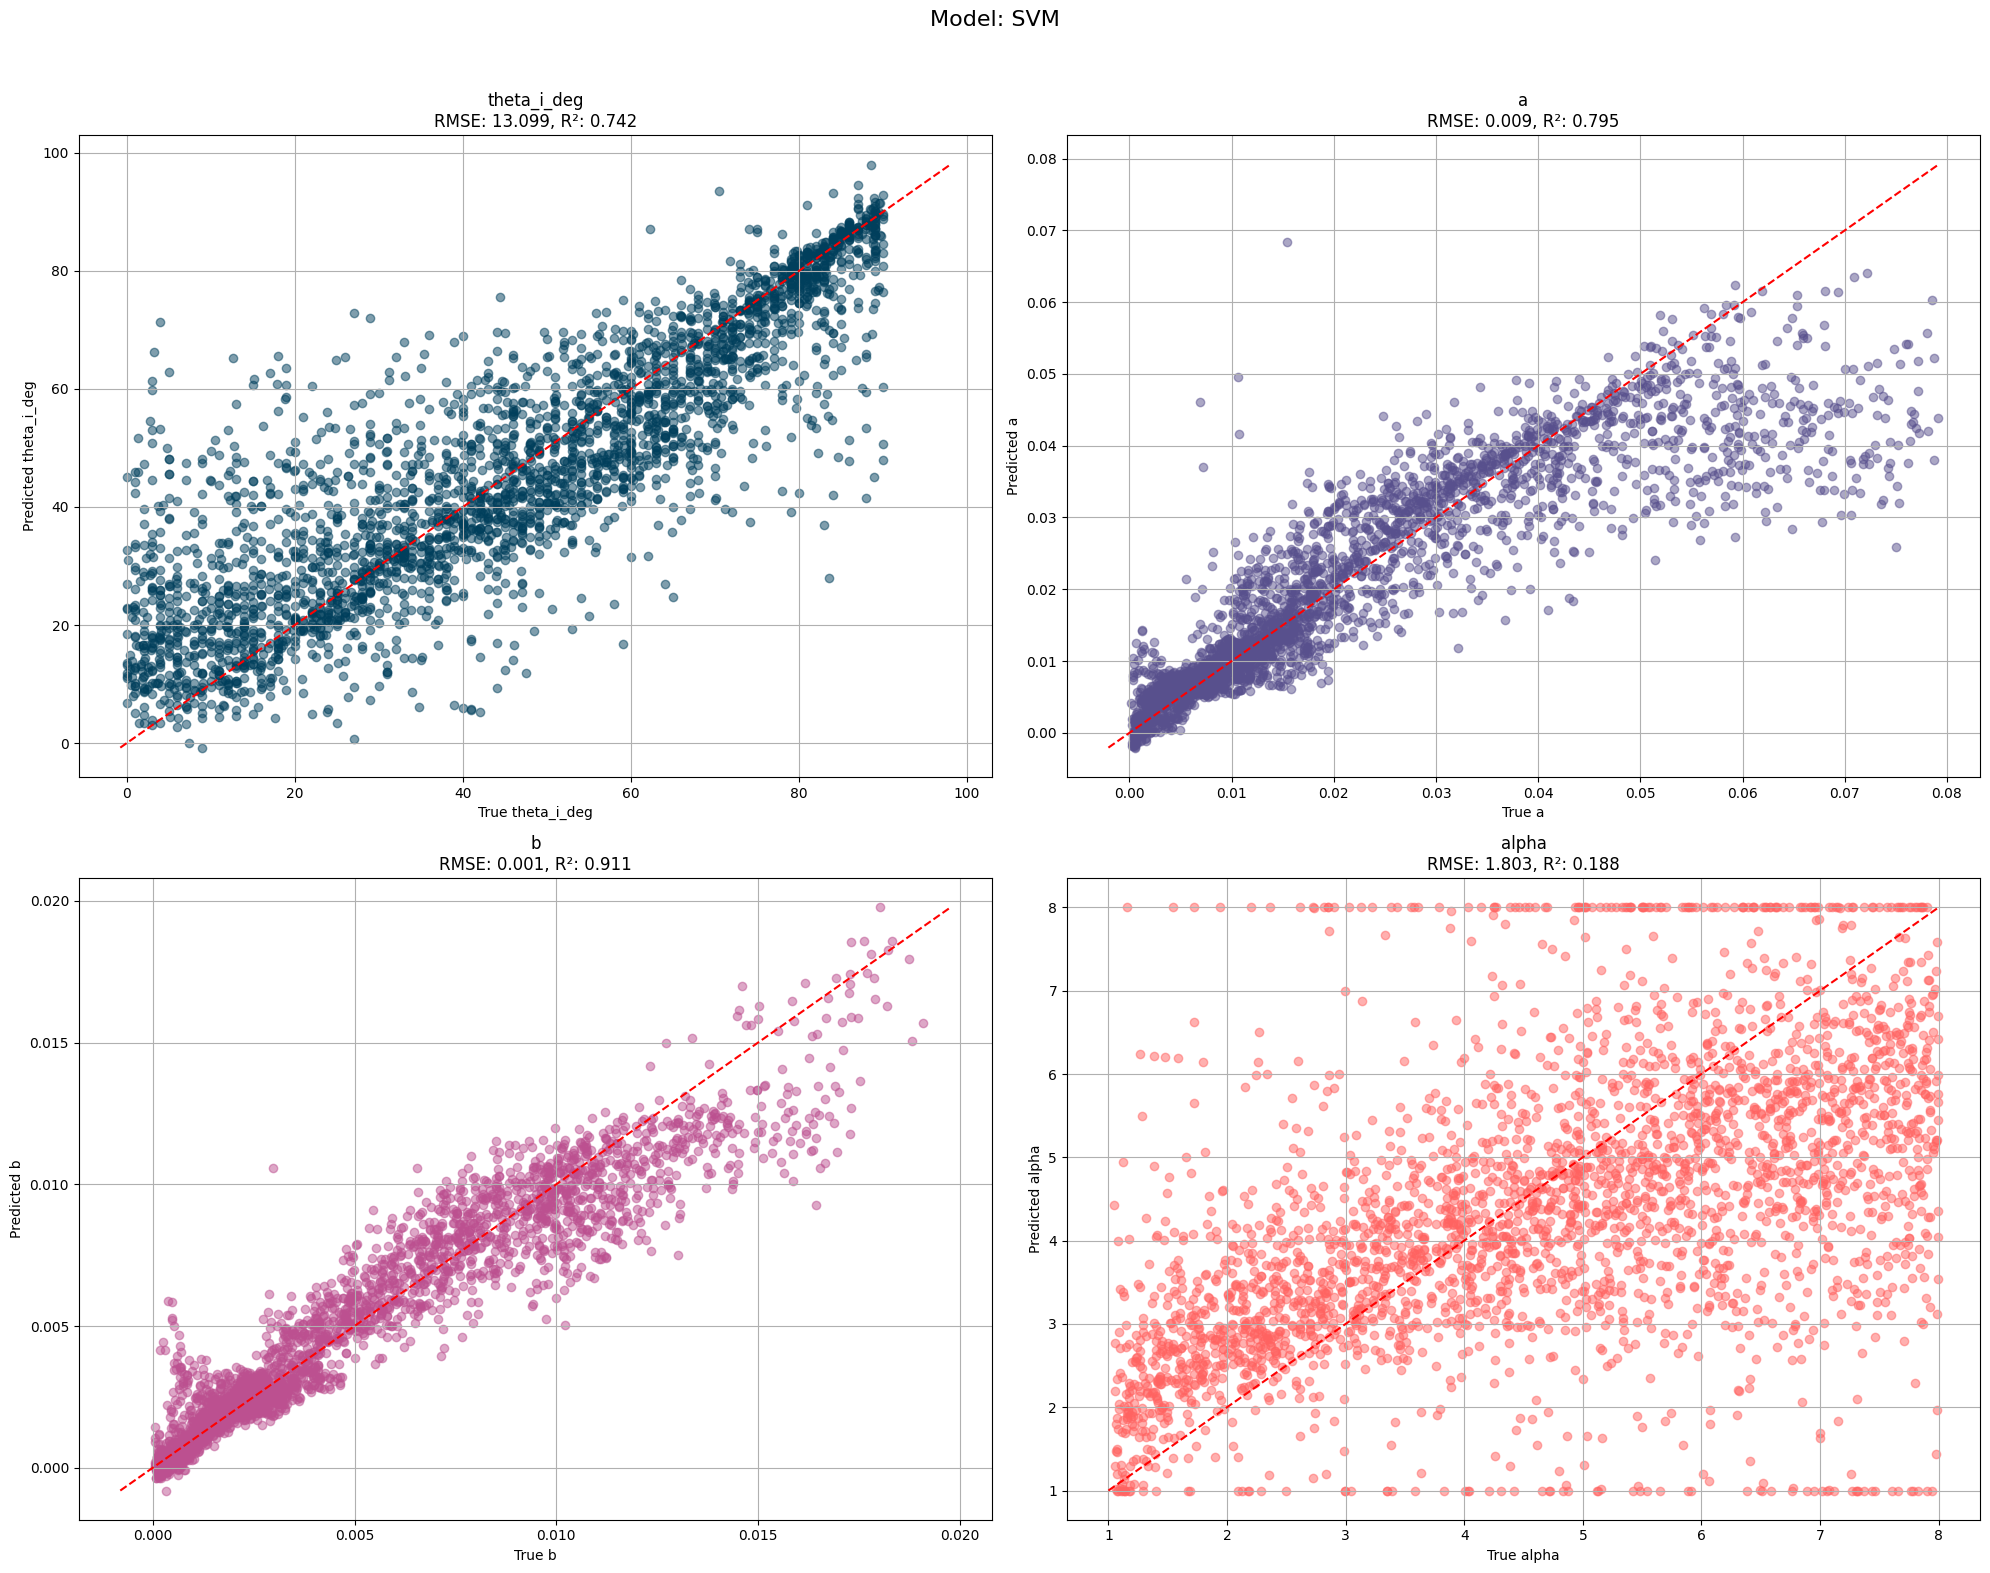


=== Random Forest Models ===
Training Random Forest Classifier...
Training completed in 177.71 seconds
Training Random Forest Regressor...
Training completed in 741.07 seconds

Evaluating Random Forest Classification model...
Classification Accuracy: 1.0000

Evaluating Random Forest Regression model...

Metrics for theta_i_deg:
RMSE: 9.8862
R² Score: 0.8531

Metrics for a:
RMSE: 0.0059
R² Score: 0.9021

Metrics for b:
RMSE: 0.0010
R² Score: 0.9415

Metrics for alpha:
RMSE: 1.2005
R² Score: 0.6401


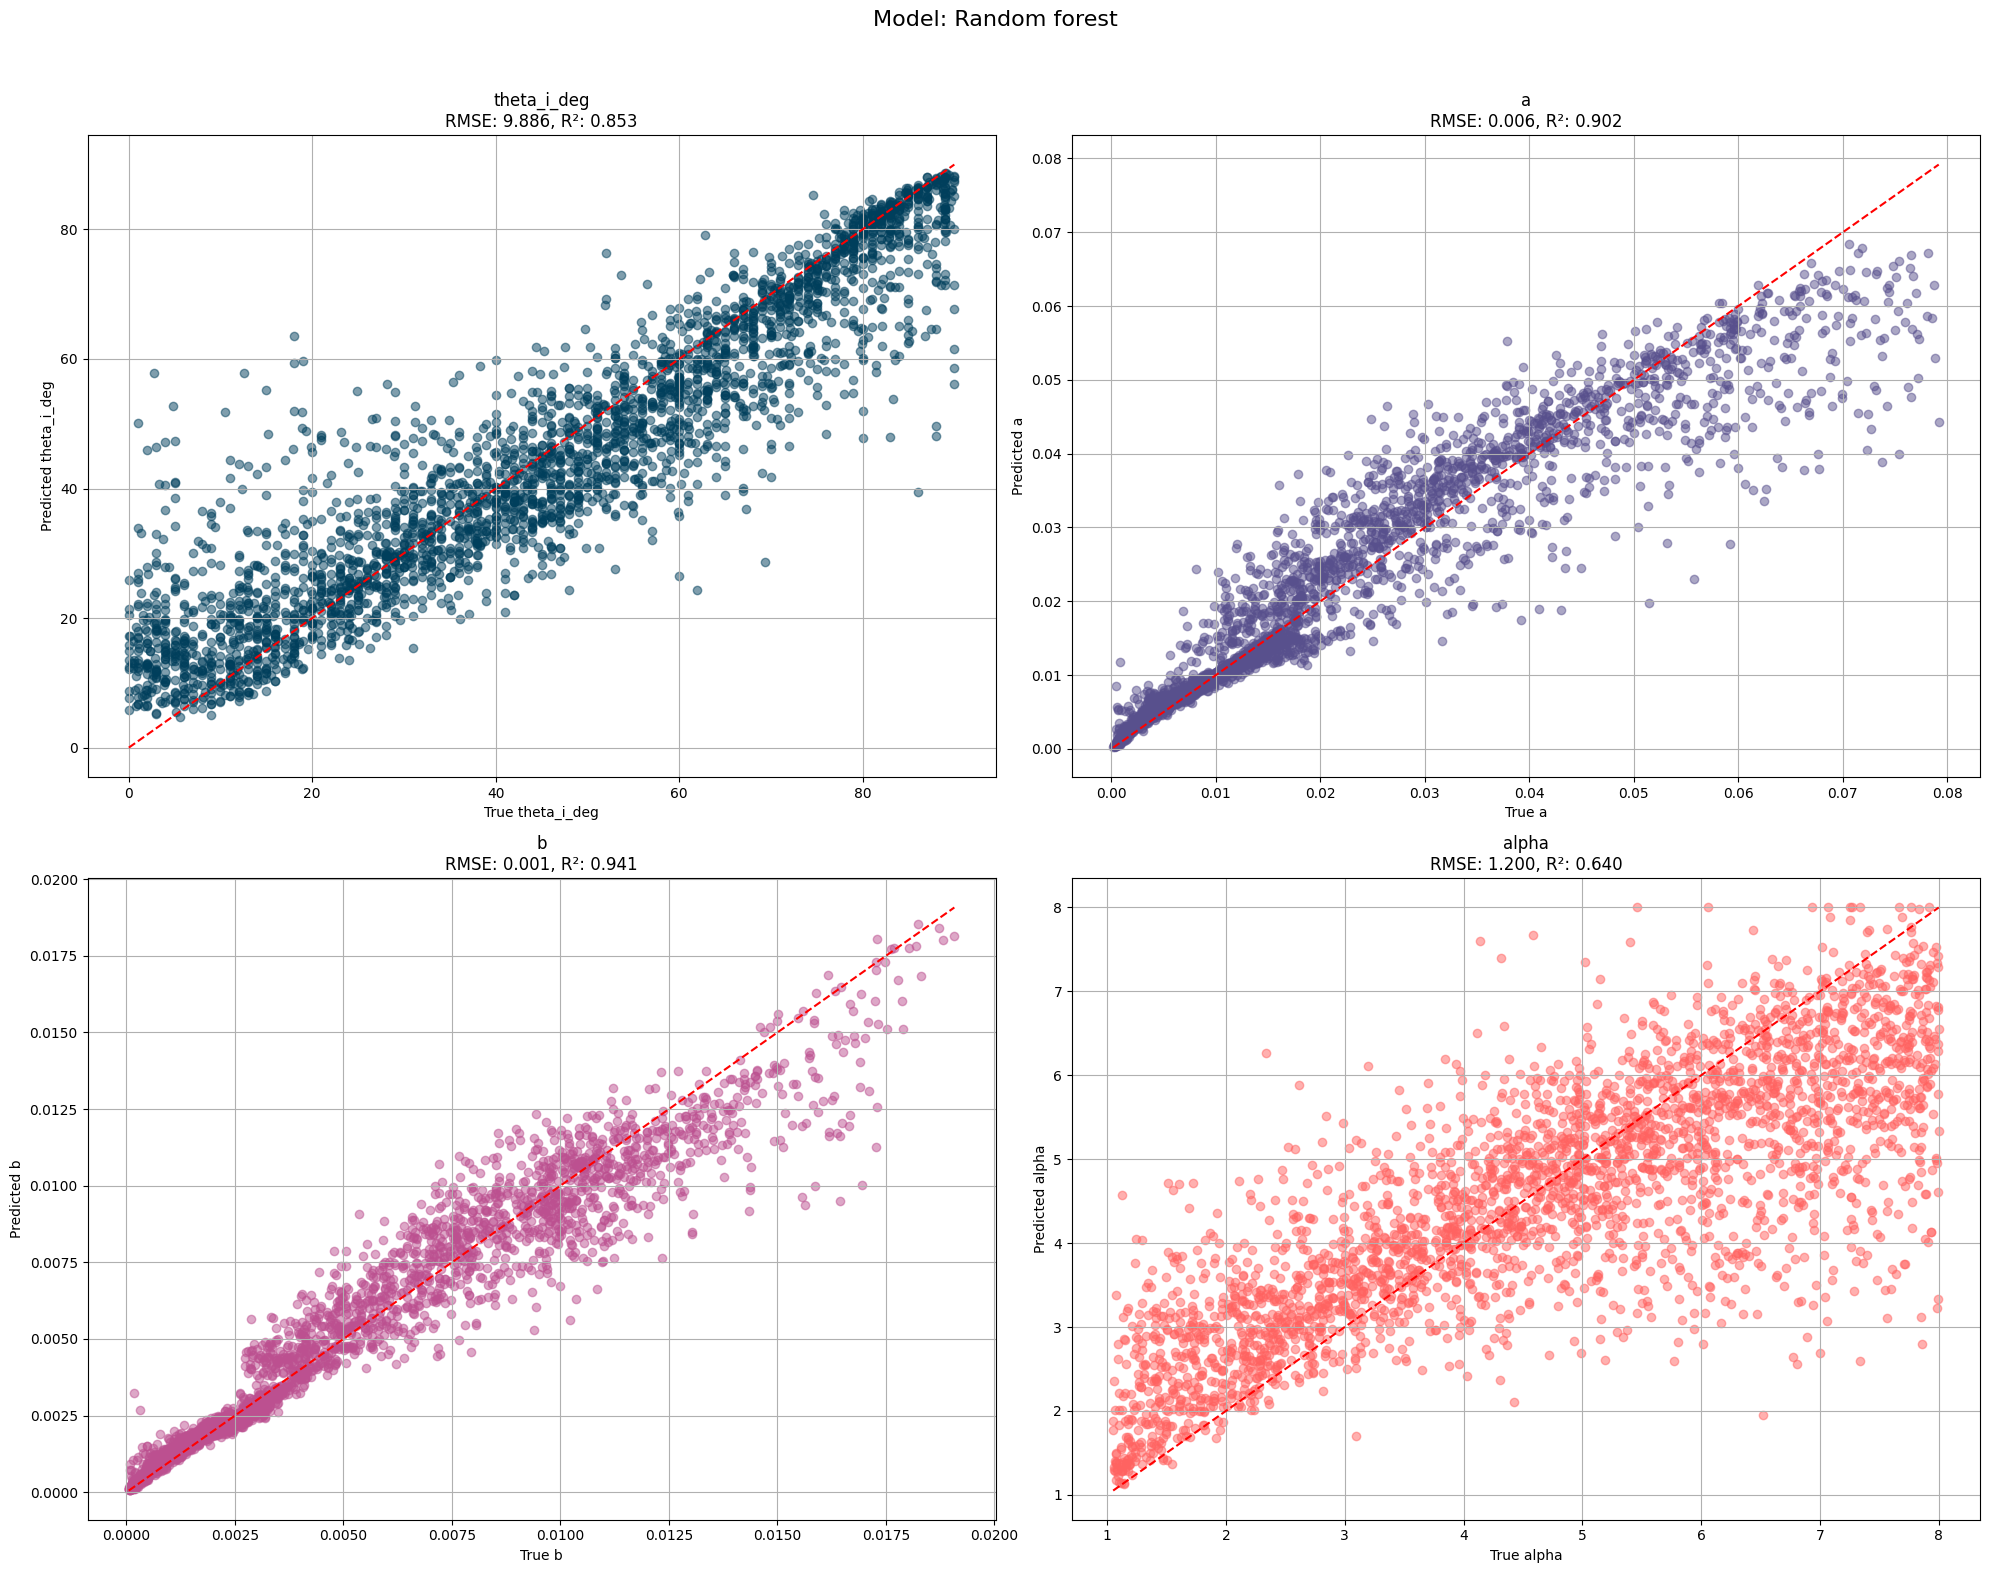

In [7]:
# 1. Train and evaluate KNN models
print("\n=== KNN Models ===")
knn_clf = train_knn_classifier(X_train_normalized, class_train)
knn_reg = train_knn_regressors(X_train_normalized, reg_train_normalized)

# KNN classification evaluation
print("\nEvaluating KNN Classification model...")
knn_class_preds = knn_clf.predict(X_test_normalized)
knn_class_accuracy = evaluate_classification(class_test, knn_class_preds, classes)

# KNN regression evaluation
print("\nEvaluating KNN Regression models...")
knn_reg_preds = np.column_stack([reg.predict(X_test_normalized) for reg in knn_reg])
knn_reg_metrics = evaluate_regression(
    reg_test_normalized[:, :3], knn_reg_preds, reg_cols, 
    reg_train_mean, reg_train_std, "KNN"
)

# 2. Train and evaluate SVM models
print("\n=== SVM Models ===")
svm_clf = train_svm_classifier(X_train_normalized, class_train)
svm_reg = train_svm_regressors(X_train_normalized, reg_train_normalized)

# SVM classification evaluation
print("\nEvaluating SVM Classification model...")
svm_class_preds = svm_clf.predict(X_test_normalized)
svm_class_accuracy = evaluate_classification(class_test, svm_class_preds, classes)

# SVM regression evaluation
print("\nEvaluating SVM Regression models...")
svm_reg_preds = np.column_stack([reg.predict(X_test_normalized) for reg in svm_reg])
svm_reg_metrics = evaluate_regression(
    reg_test_normalized[:, :3], svm_reg_preds, reg_cols, 
    reg_train_mean, reg_train_std, "SVM"
)

# 3. Train and evaluate Random Forest models
print("\n=== Random Forest Models ===")
rf_clf = train_rf_classifier(X_train_normalized, class_train)
rf_reg = train_rf_regressor(X_train_normalized, reg_train_normalized)

# Random Forest classification evaluation
print("\nEvaluating Random Forest Classification model...")
rf_class_preds = rf_clf.predict(X_test_normalized)
rf_class_accuracy = evaluate_classification(class_test, rf_class_preds, classes)

# Random Forest regression evaluation
print("\nEvaluating Random Forest Regression model...")
rf_reg_preds = rf_reg.predict(X_test_normalized)[:, :3]
rf_reg_metrics = evaluate_regression(
    reg_test_normalized[:, :3], rf_reg_preds, reg_cols, 
    reg_train_mean, reg_train_std, "Random forest"
)

Model comparison

In [8]:
# Classification accuracy comparison
print("\nClassification Accuracy Comparison:")
models = ["KNN", "SVM","Random Forest"]
accuracies = [knn_class_accuracy, svm_class_accuracy, rf_class_accuracy]

for model, acc in zip(models, accuracies):
    print(f"{model}: {acc:.4f}")


=== MODEL COMPARISON SUMMARY ===

Classification Accuracy:
KNN: 1.0000
SVM: 1.0000
Random Forest: 1.0000


Metrics


Regression RMSE (lower is better):

RMSE for theta_i_deg:
  KNN: 12.8665
  SVM: 13.0992
  Random Forest: 9.8862

RMSE for a:
  KNN: 0.0060
  SVM: 0.0086
  Random Forest: 0.0059

RMSE for b:
  KNN: 0.0011
  SVM: 0.0013
  Random Forest: 0.0010

RMSE for alpha:
  KNN: 1.4949
  SVM: 1.8028
  Random Forest: 1.2005

R² Score (higher is better):

R² for theta_i_deg:
  KNN: 0.7513
  SVM: 0.7422
  Random Forest: 0.8531

R² for a:
  KNN: 0.8982
  SVM: 0.7951
  Random Forest: 0.9021

R² for b:
  KNN: 0.9312
  SVM: 0.9106
  Random Forest: 0.9415

R² for alpha:
  KNN: 0.4419
  SVM: 0.1882
  Random Forest: 0.6401


C:\Users\sande\AppData\Local\Temp\ipykernel_30684\4057562047.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45)
C:\Users\sande\AppData\Local\Temp\ipykernel_30684\4057562047.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45)
C:\Users\sande\AppData\Local\Temp\ipykernel_30684\4057562047.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45)
C:\Users\sande\AppData\Local\Temp\ipykernel_30684\4057562047.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45)
C:\Users\sande\AppData\Local\Temp\ipykerne

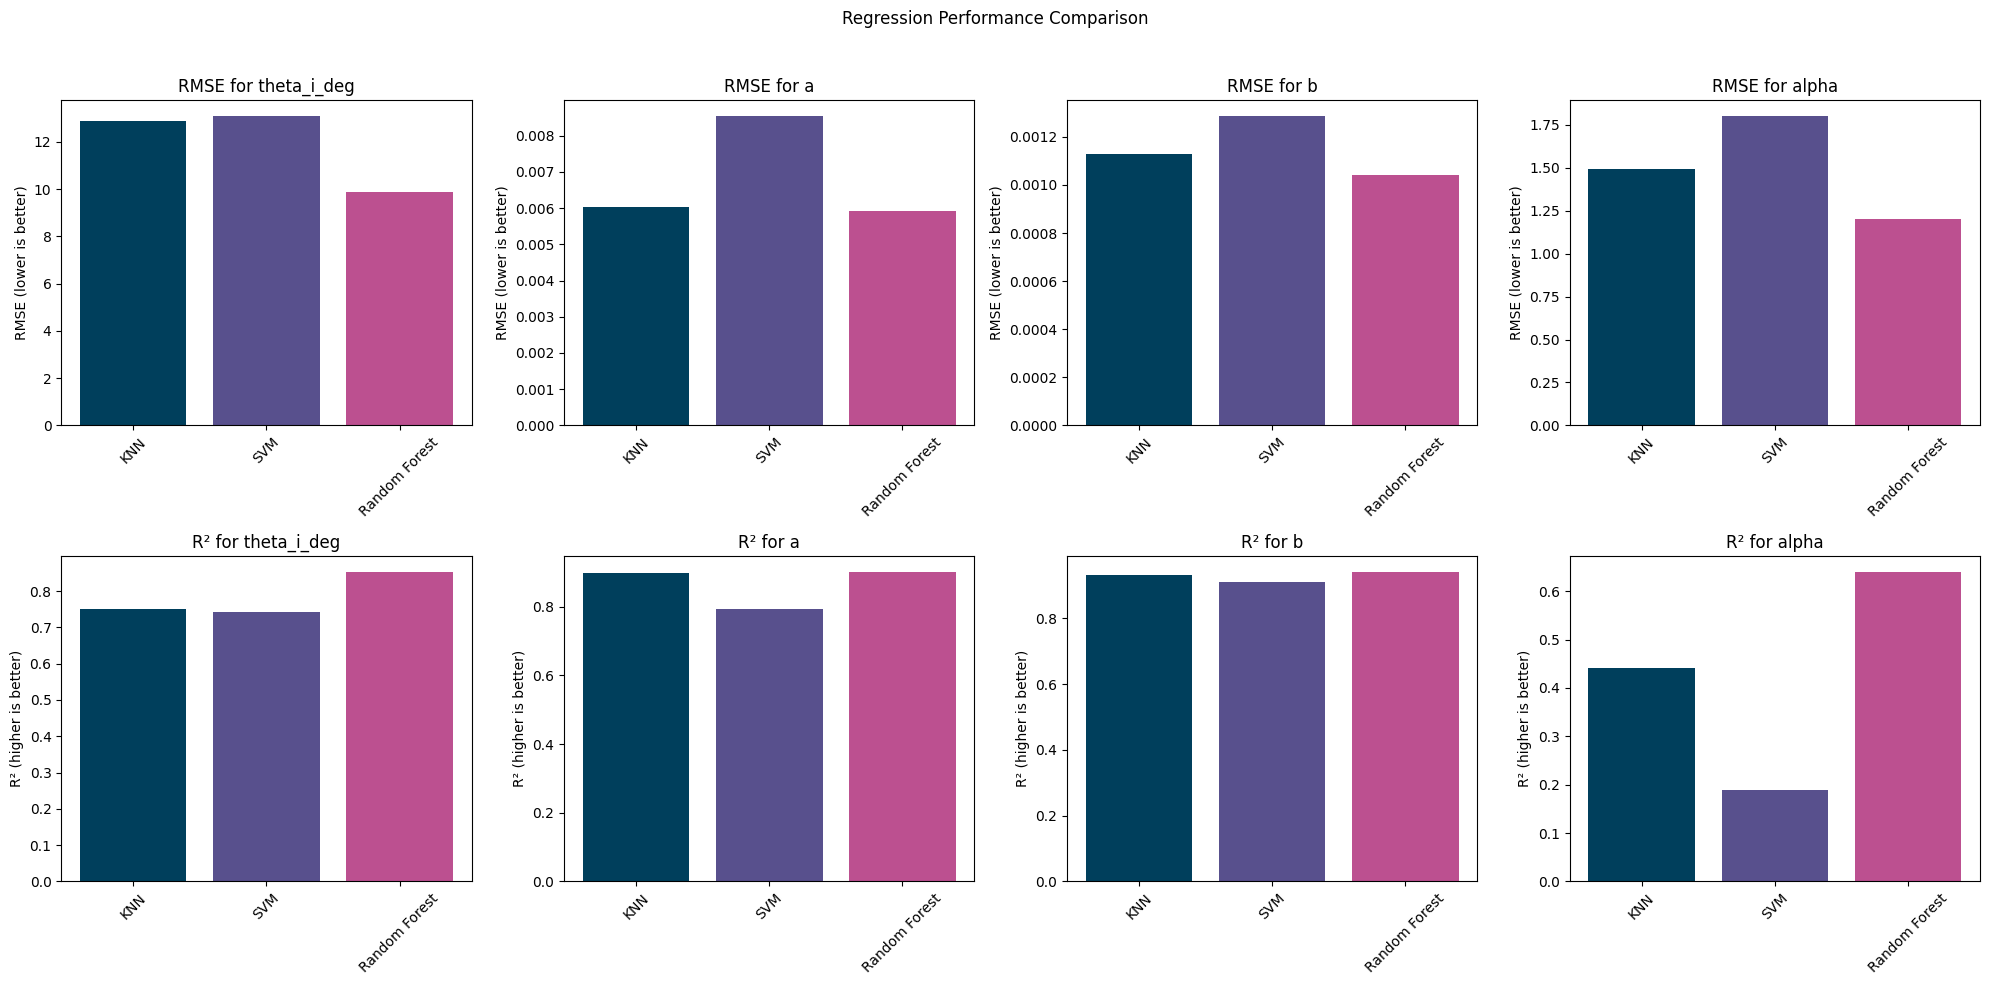


Final Analysis:
1. Classification Performance:
  Best classifier: KNN with accuracy 1.0000

2. Regression Performance:
  Best model for theta_i_deg: Random Forest with RMSE 9.8862
  Best model for a: Random Forest with RMSE 0.0059
  Best model for b: Random Forest with RMSE 0.0010
  Best model for alpha: Random Forest with RMSE 1.2005


In [9]:
# Regression performance comparison (RMSE)
print("\nRegression RMSE (lower is better):")


rmse_metrics = {model: {} for model in models}
r2_metrics = {model: {} for model in models}


for model in models:
    for param in reg_cols[:3]:
        if param in knn_reg_metrics and model == "KNN":
            rmse_metrics[model][param] = knn_reg_metrics[param]['rmse']
            r2_metrics[model][param] = knn_reg_metrics[param]['r2']
        elif param in svm_reg_metrics and model == "SVM":
            rmse_metrics[model][param] = svm_reg_metrics[param]['rmse']
            r2_metrics[model][param] = svm_reg_metrics[param]['r2']
        elif param in rf_reg_metrics and model == "Random Forest":
            rmse_metrics[model][param] = rf_reg_metrics[param]['rmse']
            r2_metrics[model][param] = rf_reg_metrics[param]['r2']
    
    #Add alpha metrics
    if 'alpha' in knn_reg_metrics and model == "KNN":
        rmse_metrics[model]['alpha'] = knn_reg_metrics['alpha']['rmse']
        r2_metrics[model]['alpha'] = knn_reg_metrics['alpha']['r2']
    elif 'alpha' in svm_reg_metrics and model == "SVM":
        rmse_metrics[model]['alpha'] = svm_reg_metrics['alpha']['rmse']
        r2_metrics[model]['alpha'] = svm_reg_metrics['alpha']['r2']
    elif 'alpha' in rf_reg_metrics and model == "Random Forest":
        rmse_metrics[model]['alpha'] = rf_reg_metrics['alpha']['rmse']
        r2_metrics[model]['alpha'] = rf_reg_metrics['alpha']['r2']

# Print RMSE metrics
for param in reg_cols:
    print(f"\nRMSE for {param}:")
    for model in models:
        print(f"  {model}: {rmse_metrics[model][param]:.4f}")

# Print R2 metrics
print("\nR² Score (higher is better):")
for param in reg_cols:
    print(f"\nR² for {param}:")
    for model in models:
        print(f"  {model}: {r2_metrics[model][param]:.4f}")


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Regression Performance Comparison')


for i, param in enumerate(reg_cols):
    # RMSE plot 
    ax1 = axes[0, i]
    rmse_values = [rmse_metrics[model][param] for model in models]
    ax1.bar(models, rmse_values, color=colors[:len(models)])
    ax1.set_title(f'RMSE for {param}')
    ax1.set_xticklabels(models, rotation=45)
    ax1.set_ylabel('RMSE (lower is better)')
    
    # R2 plot
    ax2 = axes[1, i]
    r2_values = [r2_metrics[model][param] for model in models]
    ax2.bar(models, r2_values, color=colors[:len(models)])
    ax2.set_title(f'R² for {param}')
    ax2.set_xticklabels(models, rotation=45)
    ax2.set_ylabel('R² (higher is better)')




plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Regression Performance
print("\nRegression Performance:")
for param in reg_cols:
    rmse_values = [rmse_metrics[model][param] for model in models]
    best_model_idx = np.argmin(rmse_values)
    print(f"  Best model for {param}: {models[best_model_idx]} with RMSE {rmse_values[best_model_idx]:.4f}")



Regression RMSE (lower is better):

R² Score (higher is better):

R² for theta_i_deg:
  SVM: 0.7422
  KNN: 0.7513
  Random Forest: 0.8531

R² for a:
  SVM: 0.7951
  KNN: 0.8982
  Random Forest: 0.9021

R² for b:
  SVM: 0.9106
  KNN: 0.9312
  Random Forest: 0.9415

R² for alpha:
  SVM: 0.1882
  KNN: 0.4419
  Random Forest: 0.6401

Final Analysis:
1. Classification Performance:
  Best classifier: SVM with accuracy 1.0000

2. Regression Performance:
  Best model for theta_i_deg: Random Forest with RMSE 9.8862
  Best model for a: Random Forest with RMSE 0.0059
  Best model for b: Random Forest with RMSE 0.0010
  Best model for alpha: Random Forest with RMSE 1.2005


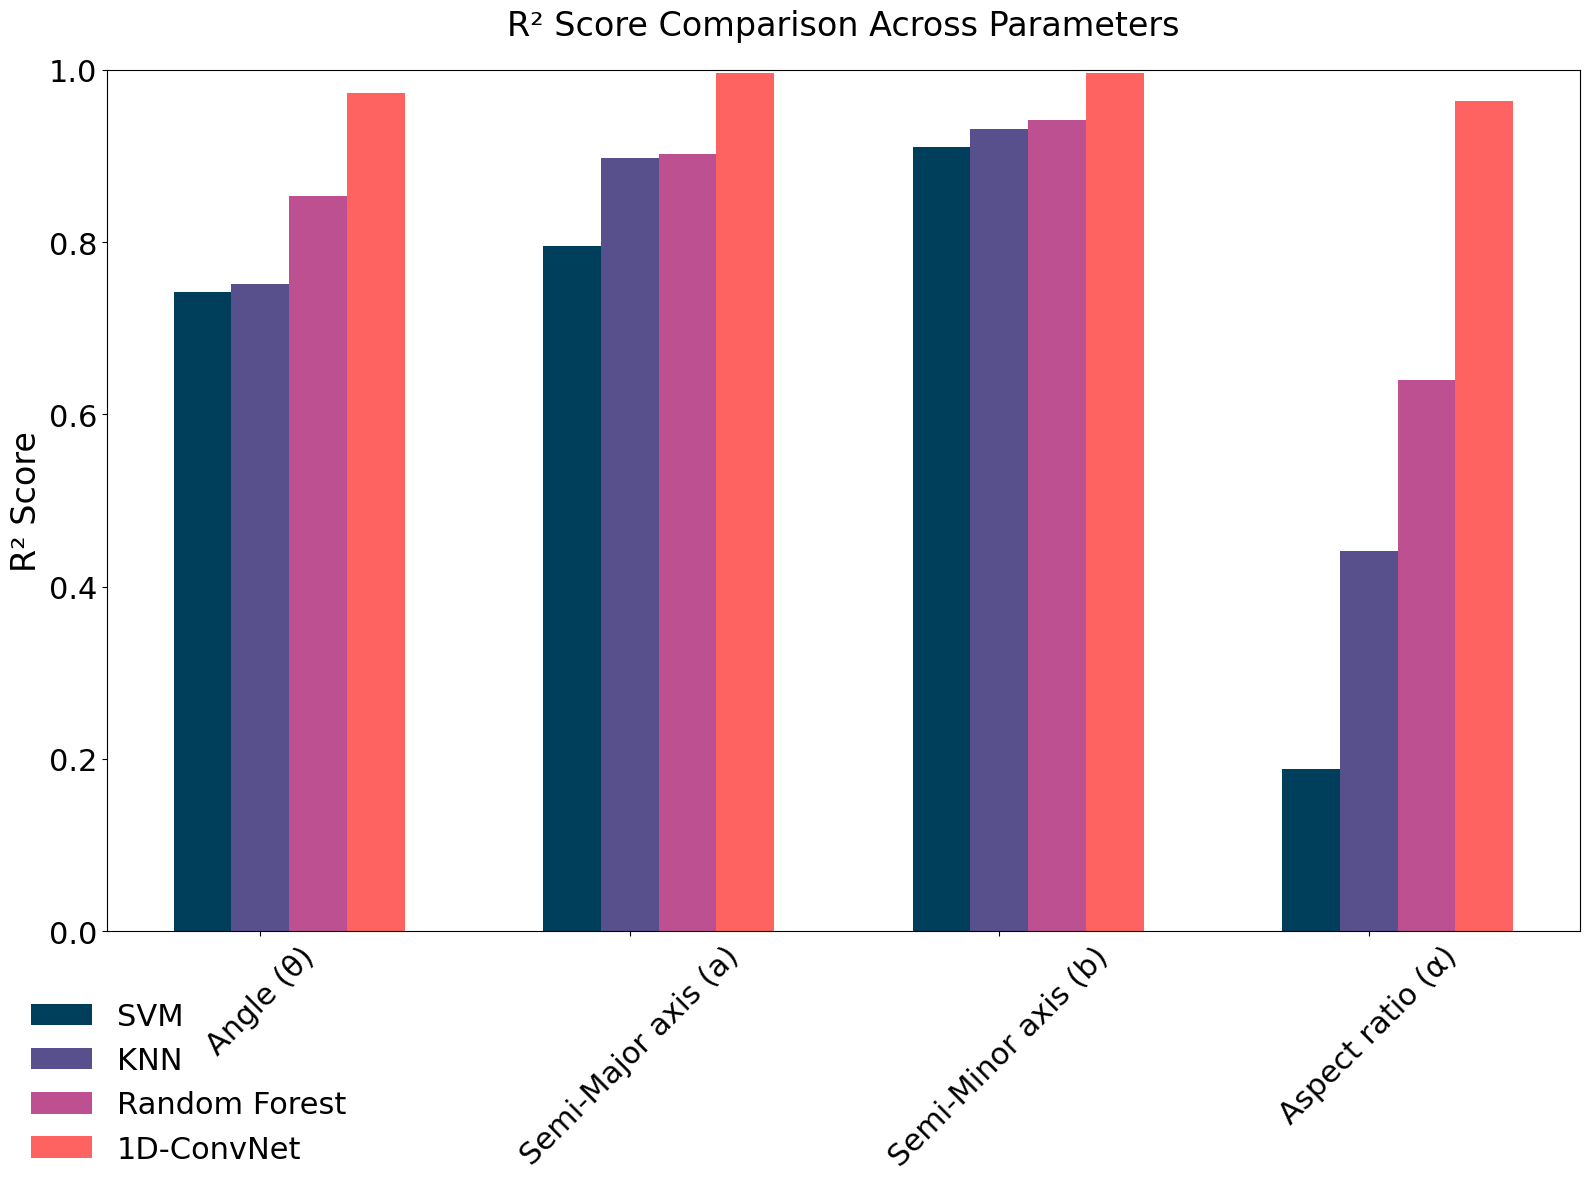

In [76]:
r2_metrics = {model: {} for model in models}


models = ["SVM", "KNN", "Random Forest"]


for model in models:
    for param in reg_cols:
        if model == "KNN" and param in knn_reg_metrics:
            r2_metrics[model][param] = knn_reg_metrics[param]['r2']
        elif model == "SVM" and param in svm_reg_metrics:
            r2_metrics[model][param] = svm_reg_metrics[param]['r2']
        elif model == "Random Forest" and param in rf_reg_metrics:
            r2_metrics[model][param] = rf_reg_metrics[param]['r2']




print("\nR² Score (higher is better):")
for param in reg_cols:
    print(f"\nR² for {param}:")
    for model in models:
        print(f"  {model}: {r2_metrics[model][param]:.4f}")


# Regression Performance
print("\nRegression Performance:")
for param in reg_cols:
    rmse_values = [rmse_metrics[model][param] for model in models]
    best_model_idx = np.argmin(rmse_values)
    print(f"Best model for {param}: {models[best_model_idx]} with RMSE {rmse_values[best_model_idx]:.4f}")



models = ["SVM", "KNN", "Random Forest", "1D-ConvNet"]
x = np.arange(len(reg_cols))*1.6 
width = 0.25 

fig, ax = plt.subplots(figsize=(16, 12))

display_names = ['Angle (θ)', 'Semi-Major axis (a)', 'Semi-Minor axis (b)', 'Aspect ratio (α)']

oned_convnet_vals = [0.9736, 0.9969, 0.9960, 0.9634] 

for i, model in enumerate(models):
    if model == '1D-ConvNet':
        r2_values = oned_convnet_vals
    else:
        r2_values = [r2_metrics[model][param] for param in reg_cols]
    
    ax.bar(x + i*width, r2_values, width, label=model, color=colors[i])


ax.set_ylabel('R² Score', fontsize=24)
ax.set_title('R² Score Comparison Across Parameters', fontsize=24,pad=25)
ax.set_xticks(x + width)
ax.tick_params(axis='y', labelsize=22)
ax.set_xticklabels(display_names,fontsize=22,  rotation=45)
ax.set_ylim(0, 1)

ax.legend(
    fontsize=22,
    framealpha=0,
    loc='upper left', 
    bbox_to_anchor=(-0.07, -0.05)
)

plt.tight_layout()

plt.savefig('../Figures/r2_comparison.png', dpi=600, bbox_inches='tight')
plt.savefig('../Figures/r2_comparison_low.png', dpi=100, bbox_inches='tight')

plt.show()



=== COMPOSITE SCORES (Accuracy + R² values averaged) ===
KNN: 0.8952
SVM: 0.8620
Random Forest: 0.9242


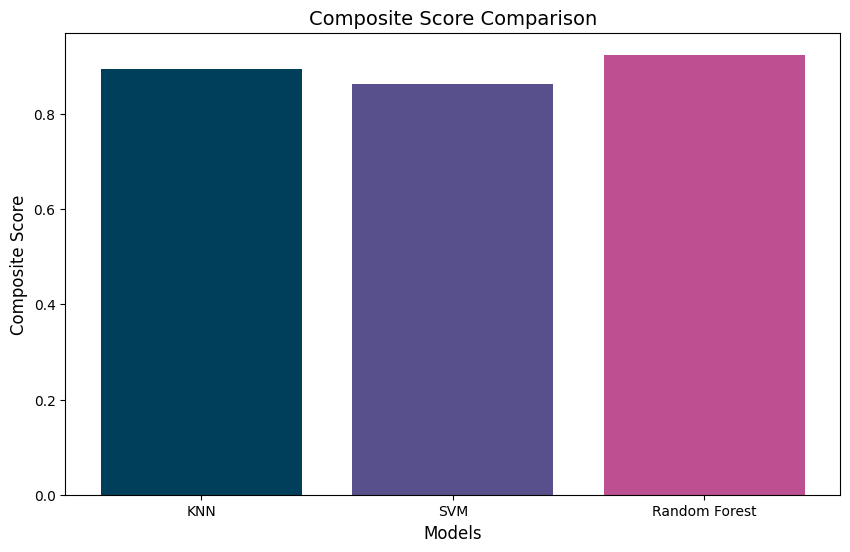

In [11]:
composite_scores = {}

for model in models:
    acc = accuracies[models.index(model)]
    
    # R2 for each regression target
    r2_theta = r2_metrics[model]['theta_i_deg']
    r2_a     = r2_metrics[model]['a']
    r2_b     = r2_metrics[model]['b']

    composite_score = (acc + r2_theta + r2_a + r2_b) / 4.0
    composite_scores[model] = composite_score

print("\n=== COMPOSITE SCORES (Accuracy + R² values averaged) ===")
for model in models:
    print(f"{model}: {composite_scores[model]:.4f}")


plt.figure(figsize=(10, 6))
plt.bar(composite_scores.keys(), composite_scores.values(), color=colors[:len(models)])
plt.xlabel('Models', fontsize=12)
plt.ylabel('Composite Score', fontsize=12)
plt.title('Composite Score Comparison', fontsize=14)

plt.show()